## Growth in a test tube
This simple example illustrates the basic workflow of COMETS, including how to build the simulation layout, to specify parameters, load the model and plot the data once the simulation is finished.

The core of the COMETS methodology is the Dynamic Flux Balance Analysis algorithm (Madahevan et al 2002). One of the first successful simulations of the time dynamics of bacterial metabolism was the classical study of *Escherichia coli* batch culture by Varma and Palsson (1994). Here, we reproduce one of the results in that study, the anaerobic fermentation in minimal media with glucose as the only carbon source.

We will simulate a test tube by setting a well-mixed virtual container with $1cm3$ of media, which we will inoculate with $5\times10^{−6}$ grams of E. coli biomass. We will set the initial composition of the substrate to 11mM of glucose and unlimited amounts of ammonia and phosphate. For the nutrient uptake, we will use standard Michaelis-Menten kinetics, using the experimentally measured Monod parameter for anaerobic uptake of glucose by E. coli.

For this simple example, we use the rudimentary "core" model of E. coli (Orth et al. 2009), which can be downloaded from http://bigg.ucsd.edu/models/e_coli_core or loaded, as we do here, using a function built in CobraPy. This model represents an E. coli metabolism simplified to its core functions (glycolysis, tricarboxylic cycle, pentose phosphate shunt, etc).


### Loading the COMETS Python Toolbox

We first import the COMETS Python toolbox, which will also load all the dependencies, such as CobraPy or pandas.

In [3]:
#Install pandas and cobra, uncomment the following two lines
#!pip install --upgrade pandas
#!pip install cobra

#The commented lines below are not needed if you installed 
#COMETS properly and you have the three lines in your ~/.zshrc file
#as described in the README file. 
#The commented lines below are an alternative way to define the paths. 

import os
os.environ['COMETS_HOME']='/Users/huangyu/Desktop/internship/comets_macos'
#See this example below and change the /Users/dukovski/Documents/Work part to your path
os.environ['COMETS_HOME']='/Users/huangyu/Desktop/internship/comets_macos/comets_2.12.3/'

import sys
comets_path=!echo $COMETS_HOME 
sys.path.append(comets_path[0]+"lib/cometspy-master/")


In [5]:

import cometspy as c
import cobra
import matplotlib.pyplot as plt

### Creating a test tube

We are now ready to create a "layout" for our simulation. By instantiating the class layout without arguments, we will create the default simulation layout, represents an empty, well mixed space (called "cell") with volume 1cm^3. We can then modify this layout according to our needs, in this case adding the media composition in the desired concentration.

In [ ]:
# 加载你的 KBase 模型
model = cobra.io.read_sbml_model('hot5f3_draft_modle.xml')

# 检查模型是否加载成功
print(f"模型 ID: {model.id}")
print(f"反应总数: {len(model.reactions)}")
print(f"代谢物总数: {len(model.metabolites)}")
print(f"基因总数: {len(model.genes)}")

In [ ]:
for rxn in model.exchanges:
    for met in rxn.metabolites:
        print(f"{rxn.id}: {met.id} - {model.metabolites.get_by_id(met.id).name}")

In [7]:
# add metabolic moduel
model = cobra.io.read_sbml_model

# Create empty 1x1 layout
test_tube = c.layout()

# Add 11mM glucose and remove o2
test_tube.set_specific_metabolite('glc__D_e', 0.11)
test_tube.set_specific_metabolite('o2_e', 1000.0)

# Add the rest of nutrients unlimited (ammonia, phosphate, water and protons)
test_tube.set_specific_metabolite('nh4_e',1000);
test_tube.set_specific_metabolite('pi_e',1000);
test_tube.set_specific_metabolite('h2o_e',1000);
test_tube.set_specific_metabolite('h_e',1000);

building empty layout model
models will need to be added with layout.add_model()


/Users/huangyu/desktop/internship/comets_macos/comets_2.12.3/lib/cometspy-master/cometspy/layout.py:831: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.media = pd.concat([self.media,


### Loading a model

Next, we have to load the model and add it to the layout (or "inoculate it in our test tube").

We will instantiate the comets model class using a loaded CobraPy model as input.

Note that we remove the bounds on glucose import, which will be set dynamically by COMETS during the simulation according to the dynamically changing external glucose concentration. We will set the initial biomass of our model at $10^{-6}$ grams.

In [2]:
# create the model using CobraPy functionality
e_coli_cobra = cobra.io.load_model('textbook')

test_tube.grid = [1,1]
# use the loaded model to build a comets model
e_coli=c.model(e_coli_cobra)
# remove the bounds from glucose import (will be set dynamically by COMETS)
e_coli.change_bounds('EX_glc__D_e', -1000, 1000)
e_coli.change_bounds('EX_ac_e', -1000, 1000)
e_coli.change_bounds('ATPM', 8, 1000)

# set the model's initial biomass
e_coli.initial_pop = [0, 0, 5e-6]
  
#You can add demographic noise if you wish    
#e_coli.neutralDrift = False
#e_coli.add_neutral_drift_parameter = 0.001

#The default optimizer is the OR-Tool glop
#You can change it to Gurobi if you prefer that
e_coli.optimizer="GLOP"

#The default optimization method is to maximize the biomass growth rate.
#You can emply parsimonious FBA: First maximize the biomass growth, then minimize the sum of the 
#absolute values of all fluxes.
e_coli.obj_style="MAX_OBJECTIVE_MIN_TOTAL"


# add it to the test_tube
test_tube.add_model(e_coli)

NameError: name 'cobra' is not defined

### Setting the simulation parameters

We next instantiate the params class, which generates a set of parameters for the COMETS simulation with the [TODO LINK TO DEF VALS] default values for all of them. All of the parameters are contained in the all_params field which is a Python dict object, making it easy to change the value of the desired parameters.

In [9]:
# Set the parameters that are different from the default
sim_params = c.params()

In [10]:
sim_params.set_param('numRunThreads', 1)
sim_params.set_param('defaultVmax', 18)
sim_params.set_param('defaultKm', 0.000003)
sim_params.set_param('maxCycles', 2000)
sim_params.set_param('timeStep', 0.01)
sim_params.set_param('spaceWidth', 1)
sim_params.set_param('maxSpaceBiomass', 10)
sim_params.set_param('minSpaceBiomass', 1e-11)
sim_params.set_param('writeMediaLog', True)
sim_params.set_param('deathRate', 0.0)

### Running the simulation

With all set up, we can now instantiate the comets class by passing the layout (containing the model) and the params objects we just created.

In [12]:
#You can write the input files for reference if you wish.
#test_tube.write_layout("/projectnb/cometsfba/dukovski/Work/Ecoli_cometspy_notebooks/layout")
#test_tube.write_necessary_files("/projectnb/cometsfba/dukovski/Work/Ecoli_cometspy_notebooks/")

#Create an experiment.
experiment = c.comets(test_tube, sim_params)

Finally, we can run the simulation as:

In [14]:
experiment.run()


Running COMETS simulation ...

Debug Here ...
Done!


/Users/dukovski/Documents/Work/comets_macos/comets_2.12.3/lib/cometspy-master/cometspy/comets.py:455: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.media = pd.read_csv(self.working_dir + self.parameters.all_params[


In [15]:
print(experiment.run_output)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Analyzing the results

The results of our simulation are stored in several pandas data frames contained in the comets object that we just simulated. The growth of the simulated model can be seen by plotting the total_biomass field.

Text(0, 0.5, 'Biomass (gr.)')

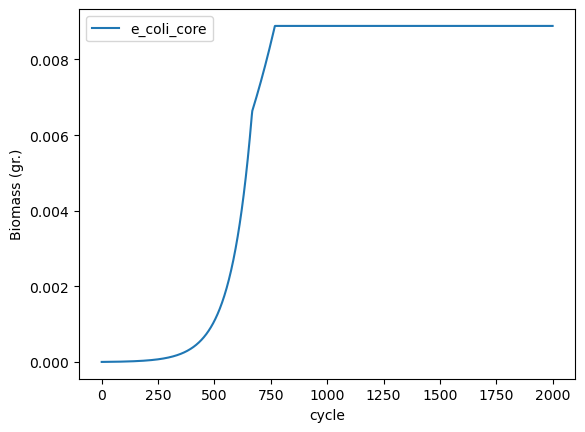

In [17]:
ax = experiment.total_biomass.plot(x = 'cycle')
ax.set_ylabel("Biomass (gr.)")
#ax.set_ylim([0,0.0006])

Similarly, we can plot composition of the media. In this case, we will limit the plot to those components that are not added to the layout in unlimited amounts (“static” compounds, e.g. ammonia, phosphate, water, etc in this simulation). In this case, we do this by limiting the plot to compounds with concentration lower than 900mM.

(0.0, 0.35)

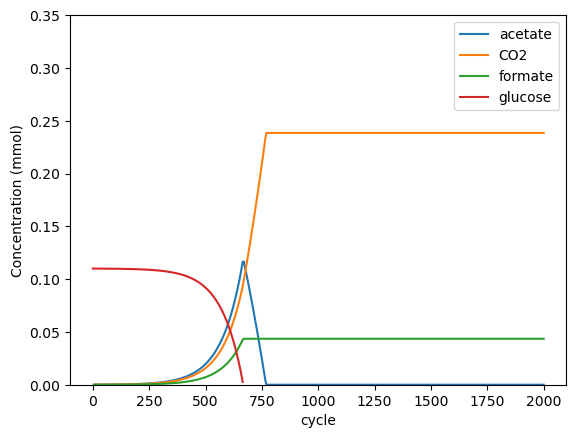

In [19]:
media = experiment.media.copy()
media = media[media.conc_mmol<900]

fig, ax = plt.subplots()
media.groupby('metabolite').plot(x='cycle', ax =ax, y='conc_mmol')
ax.legend(('acetate','CO2', 'formate', 'glucose'))
ax.set_ylabel("Concentration (mmol)")
ax.set_ylim([0,0.35])

In [20]:
media[media.cycle==5]

,metabolite,cycle,x,y,conc_mmol
6,ac_e,5,1,1,0.000005
7,co2_e,5,1,1,0.000004
8,for_e,5,1,1,0.000002
9,glc__D_e,5,1,1,0.109995
